In [1]:
!pip install config type
!pip install transitions

  Using cached https://files.pythonhosted.org/packages/59/6c/4ab0d80b22dca3baab49670b75ae2183b59649e9f27c11018075e509048e/config-0.4.2.tar.gz
  Could not find a version that satisfies the requirement type (from versions: )
No matching distribution found for type
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
jupyterlab-server 1.0.6 has requirement jsonschema>=3.0.1, but you'll have jsonschema 2.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import uuid
import os
from os import path
from glob import glob
import json
import re
import pickle
import argparse

import numpy as np
from textwrap import wrap
from scipy import ndimage, misc

#import config
#from type import RecipeContainer, DataContainer
#from utils import url_to_filename

# import matplotlib using agg backend
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

In [3]:
import boto3
import sagemaker

bucket   = sagemaker.Session().default_bucket() # or replace with your preferred s3 bucket
print(bucket)
prefix   = 'w/tty'

sagemaker-us-east-1-111652037296


In [4]:
users_filename        = 'users.csv'
interactions_filename = 'interactions.csv'
int_exp_filename      = 'interactions_expanded.csv'

In [5]:
NUM_INTERACTIONS = 750000
NUM_USERS        = 30000

In [6]:
SESSION_LEN           = 10
SESSION_DELAY_SECONDS = 2 * 60 # 2 minutes

NUM_SESSIONS = NUM_INTERACTIONS // SESSION_LEN

SECONDS_SINCE_OLDEST_INTERACTION = 60* 60 * 24 * 7 # a week ago
MOST_RECENT_TIMESTAMP = round(datetime.datetime.now().timestamp())

In [7]:
def date_to_string(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [8]:
zip_codes_df = pd.read_csv('zip_codes.csv')
print(zip_codes_df.shape)
zip_codes_df.head()

(100, 3)


,ZIP_CODE,CITY,INCOME
0,79936,El Paso TX,42857
1,90011,Los Angeles CA,23851
2,60629,Chicago IL,40279
3,90650,Norwalk CA,46012
4,90201,Bell Gardens CA,30029


In [9]:
def gen_users(num_users):
    _users = []
    
    _zip_len = zip_codes_df.shape[0]
    
    for i in range(num_users):
        _age        = int(np.random.normal(40, 4))
        _gender_idx = np.random.randint(0, 2)
        _loc_idx    = np.random.randint(0, _zip_len)
        if _gender_idx == 0:
            _gender = 'MALE'
        else:
            _gender = 'FEMALE'
            
        _this_user = [str(i), _age, _gender, 
                      str(zip_codes_df.iloc[_loc_idx][0]), 
                      zip_codes_df.iloc[_loc_idx][2]]
        
        _users.append(_this_user)
        
    _df = pd.DataFrame(_users, columns=['USER_ID', 'AGE', 'GENDER', 'LOCATION', 'SALARY'])
    return _df

In [10]:
users_df = gen_users(NUM_USERS)
print(users_df.shape)
users_df.head()

(30000, 5)


,USER_ID,AGE,GENDER,LOCATION,SALARY
0,0,46,MALE,11373,38151
1,1,40,FEMALE,78572,23799
2,2,38,MALE,60618,41355
3,3,35,MALE,79912,48627
4,4,38,MALE,93033,46342


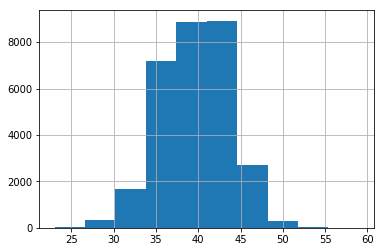

In [11]:
users_df['AGE'].hist()

In [12]:
users_df['LOCATION'].value_counts()[0:10]

90280    337
23464    333
91709    331
92704    329
37013    327
95823    326
10025    325
10453    324
91910    324
11206    323
Name: LOCATION, dtype: int64

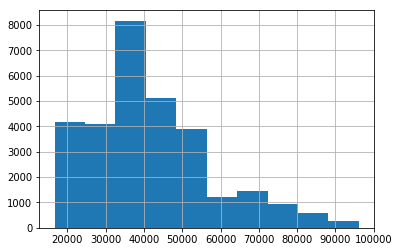

In [13]:
users_df['SALARY'].hist()

In [14]:
def load_recipe(filename):
    """Load a single recipe collection from disk."""
    with open(filename, 'r') as f:
        recipes = json.load(f)
    print('Loaded {:,} recipes from {}'.format(len(recipes), filename))
    return recipes

In [15]:
recipe = load_recipe('recipes/recipes_raw_nosource_ar.json')

Loaded 39,802 recipes from recipes/recipes_raw_nosource_ar.json


In [16]:
i = 0
for key, value in recipe.items():
    print(json.dumps(key, indent=4))
    i += 1
    if (i>10):
        break

"rmK12Uau.ntP510KeImX506H6Mr6jTu"
"5ZpZE8hSVdPk2ZXo1mZTyoPWJRSCPSm"
"clyYQv.CplpwJtjNaFGhx0VilNYqRxu"
"BmqFAmCrDHiKNwX.IQzb0U/v0mLlxFu"
"N.jCksRjB4MFwbgPFQU8Kg.yF.XCtOi"
"kq.naD.8G19M4UU9dVvJgHtpfo.l/eC"
"lYrgWNn00EXblOupzM3tL0jGr9O0CB2"
"Fu0DgGYFUGwc0BBlN6r20o/ihOVs5bO"
"MBRNtqELRRuv8zJH4k7Aba2bmIc2A3C"
"ZPyPoMiNvgAfrKcRpH9FEYV/XsPZBsW"
"ATMxl11LFhuvTbTi9.kX4nhYE50HeJ."


In [17]:
users_df.head()

,USER_ID,AGE,GENDER,LOCATION,SALARY
0,0,46,MALE,11373,38151
1,1,40,FEMALE,78572,23799
2,2,38,MALE,60618,41355
3,3,35,MALE,79912,48627
4,4,38,MALE,93033,46342


In [18]:
dil = users_df.sample(n=1)['USER_ID'].values[0]
print(dil)

439


In [19]:
"""

_session_len = SESSION_LEN
num_interactions = NUM_INTERACTIONS 
_num_sessions = num_interactions // _session_len

SECONDS_SINCE_OLDEST_INTERACTION = 60* 60 * 24 * 7 # a week ago
MOST_RECENT_TIMESTAMP = round(datetime.datetime.now().timestamp())

_most_recent_time = MOST_RECENT_TIMESTAMP - (60 * 60 * 2) - ((SESSION_LEN + 1) * SESSION_DELAY_SECONDS)
_oldest_time      = _most_recent_time - SECONDS_SINCE_OLDEST_INTERACTION
    
print('Oldest session starts: {}, Newest: {}'.format(date_to_string(_oldest_time),
                                                         date_to_string(_most_recent_time)))
                                                         
"""                                                         

"\n\n_session_len = SESSION_LEN\nnum_interactions = NUM_INTERACTIONS \n_num_sessions = num_interactions // _session_len\n\nSECONDS_SINCE_OLDEST_INTERACTION = 60* 60 * 24 * 7 # a week ago\nMOST_RECENT_TIMESTAMP = round(datetime.datetime.now().timestamp())\n\n_most_recent_time = MOST_RECENT_TIMESTAMP - (60 * 60 * 2) - ((SESSION_LEN + 1) * SESSION_DELAY_SECONDS)\n_oldest_time      = _most_recent_time - SECONDS_SINCE_OLDEST_INTERACTION\n    \nprint('Oldest session starts: {}, Newest: {}'.format(date_to_string(_oldest_time),\n                                                         date_to_string(_most_recent_time)))\n                                                         \n"

In [20]:
"""

i = 0
s = uuid.uuid1().int>>64        
_interactions = []
user_in_interaction = 1

for key, value in recipe.items():

    _item = key
    #print(json.dumps(key, indent=4))
    
    i += 1
    
    _user = users_df.iloc[i]['USER_ID']
    #print(users_df.iloc[i]['USER_ID'])
    
    _when = np.random.randint(_oldest_time, _most_recent_time)
    #print(np.random.randint(_oldest_time, _most_recent_time))
    
    if (i % 5 == 0):
        s = uuid.uuid1().int>>64        
        user_in_interaction = str(_user)
        
    _this_interaction = [user_in_interaction, str(_item), _when, s]
    #print(_this_interaction)
    
    _interactions.append(_this_interaction)
    
    if (i>5000):
        break
        
_df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'SESSION_ID'])      
"""

"\n\ni = 0\ns = uuid.uuid1().int>>64        \n_interactions = []\nuser_in_interaction = 1\n\nfor key, value in recipe.items():\n\n    _item = key\n    #print(json.dumps(key, indent=4))\n    \n    i += 1\n    \n    _user = users_df.iloc[i]['USER_ID']\n    #print(users_df.iloc[i]['USER_ID'])\n    \n    _when = np.random.randint(_oldest_time, _most_recent_time)\n    #print(np.random.randint(_oldest_time, _most_recent_time))\n    \n    if (i % 5 == 0):\n        s = uuid.uuid1().int>>64        \n        user_in_interaction = str(_user)\n        \n    _this_interaction = [user_in_interaction, str(_item), _when, s]\n    #print(_this_interaction)\n    \n    _interactions.append(_this_interaction)\n    \n    if (i>5000):\n        break\n        \n_df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'SESSION_ID'])      \n"

In [21]:
type(recipe.items())

dict_items

In [22]:
import random, datetime, transitions, uuid
from transitions import MachineError
import datetime

i = 0
s = uuid.uuid1().int>>64        

'''
0 - 'dislike' - Left swipe (Interaction = disliked)
10 - 'open' - Opened (Interaction = opened activity)
20 - 'sharedf' - Shared with friend (Interaction = shared with friend)
30 - 'like' - Right swipe (Interaction = liked)
40 - 'sharedt' - Shared on timeline (Interaction = shared on timeline)
50 - 'sharede' - Shared on external (Interaction = shared on external)
60 - 'addc' - Added content (Interaction = added content)
70 - 'addposcom' - Added positive comment
80 - 'activityc' - Children activity created (Interaction = children activity created)
90 - 'purchased' - Purchased (Interaction = purchased)
100 - 'done' - Done (Interaction = Done, Performed)
'''

# SM1  open --> like --> done
# SM2  open --> like --> purchased --> done
# SM3  open --> dislike
# SM4  open --> like --> done --> sharedf
# SM5  open --> like --> done --> sharedf --> sharede
# SM6  open --> like --> done --> sharedf --> sharede --> addposcom
# SM7  open --> like --> purchased --> done --> sharedf --> sharede --> addposcom 

from transitions import Machine
import random

#SM7  open --> like --> purchased --> done --> sharedf --> sharede --> addposcom 
class SM(object):
    pass
# The states
# And some transitions between states. We're lazy, so we'll leave out
# the inverse phase transitions (freezing, condensation, etc.).
states=['dislike', 'open', 'sharedf', 'like', 'sharedt', 'sharede', 'addc', 'addposcom', 'activityc', 'purchased', 'done']

sm7 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'purchased' },
    { 'trigger': 'next', 'source': 'purchased', 'dest': 'done' },
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'next', 'source': 'sharedf', 'dest': 'sharede' },
    { 'trigger': 'next', 'source': 'sharede', 'dest': 'addposcom' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m7 = Machine(sm7, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM1  open --> like --> done

sm1 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m1 = Machine(sm1, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)


# SM2  open --> like --> purchased --> done << TODO DSL 
sm2 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'purchased' },
    { 'trigger': 'next', 'source': 'purchased', 'dest': 'done' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m2 = Machine(sm2, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM3  open --> dislike
sm3 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'dislike' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m3 = Machine(sm3, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM4  open --> like --> done --> sharedf
sm4 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m4 = Machine(sm4, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM5  open --> like --> done --> sharedf --> sharede
sm5 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'next', 'source': 'sharedf', 'dest': 'sharede' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m5 = Machine(sm5, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM6  open --> like --> done --> sharedf --> sharede --> addposcom
sm6 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },    
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'next', 'source': 'sharedf', 'dest': 'addposcom' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m6 = Machine(sm6, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# VALUES columns=['USER_ID', 'ITEM_ID', 'EVENT_TYPE',' EVENT_VALUE', 'TIMESTAMP']

user_actions = {
    "dislike":"0",
    "open":"10",
    "sharedf":"20",
    "like":"30",
    "sharedt":"40",
    "sharede":"50",
    "addc":"60",
    "addposcom":"70",
    "activityc":"80",
    "purchased":"90",
    "done":"100"
}

sm_tuple = [sm1, sm2, sm3, sm4, sm5, sm6, sm7]
_interactions = []

for i in range(1, 20000): #Each user users_df.size - use this
#for key, value in recipe.items():
    #_item = key
    # Here with sample, we are taking 1 random sample
    user_id = users_df.sample(n=1)['USER_ID'].values[0]
    user_action = random.choice(list(user_actions))
    item_id = random.choice(list(recipe.items()))[0]
    
    if(i % 5 == 0): #how many parallel sessions? if its 5 then 5 sessions
        session_start_time = (datetime.datetime.now() + datetime.timedelta(minutes=random.randint(1,600))).timestamp()
    
    #State machine loop
    #Select random State Machine 
    
    selected_sm = sm_tuple[random.randrange(len(sm_tuple))]
    timestep_sm = random.randint(1,600)    
    selected_sm.reset()

    while True: 
        try:
            interaction_time_stamp = round((datetime.datetime.now() + datetime.timedelta(minutes=timestep_sm)).timestamp())
            #columns=['USER_ID', 'ITEM_ID', 'EVENT_TYPE',' EVENT_VALUE', 'TIMESTAMP']
            #print('{}, {}, {}, {}, {}'.format(user_id, item_id, selected_sm.state, user_actions[selected_sm.state], interaction_time_stamp))
            _this_interaction = [user_id, item_id, selected_sm.state, user_actions[selected_sm.state], interaction_time_stamp]
            #_this_interaction = [user_id, item_id, interaction_time_stamp]
            
            #print(_this_interaction)
            
            _interactions.append(_this_interaction)
            #choice = random.choice(list(recipe.items()))
            #print(choice[0])
            timestep_sm = timestep_sm + random.randint(1,600)
            selected_sm.next()
        except MachineError as e:
            #print('endstate')
            break
        else:
            continue            
            
_df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'EVENT_TYPE', 'EVENT_VALUE', 'TIMESTAMP'])
#_df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP'])            

In [23]:
s

13943355192344252906

In [24]:
_df.head()

,USER_ID,ITEM_ID,EVENT_TYPE,EVENT_VALUE,TIMESTAMP
0,2915,aFu4TE6d6f6R2dcfG4CABpa50hbdW3u,open,10,1576613611
1,2915,aFu4TE6d6f6R2dcfG4CABpa50hbdW3u,dislike,0,1576616311
2,24771,v0BLTva9ceGdOELD4UdC0gsKGZXGn5m,open,10,1576605571
3,24771,v0BLTva9ceGdOELD4UdC0gsKGZXGn5m,dislike,0,1576630711
4,29741,luKxU73rtr0lKwcST2bX/Hfby8ozqGq,open,10,1576593451


In [25]:
_df.size

429795

In [26]:
#_df.isnull()

In [27]:
import boto3

import json
import numpy as np
import pandas as pd
import time

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

suffix = str(np.random.uniform())[4:9]

In [28]:
bucket = "wtty-" + str(suffix)       # replace with the name of your S3 bucket
filename = "generated_data.csv"

In [29]:
_df.to_csv(filename, index=False)

In [30]:
s3 = boto3.client('s3')
s3.create_bucket(Bucket=bucket)

{'ResponseMetadata': {'RequestId': '759EC17B6FAEEB26',
  'HostId': '7b6Cb01Cle8ezjmIMM7KskyhxCSPKzqgtdJDWHr9GaPM3ecutL87VNNh4Mer7YvAHVuLaKLUZeo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7b6Cb01Cle8ezjmIMM7KskyhxCSPKzqgtdJDWHr9GaPM3ecutL87VNNh4Mer7YvAHVuLaKLUZeo=',
   'x-amz-request-id': '759EC17B6FAEEB26',
   'date': 'Tue, 17 Dec 2019 12:35:41 GMT',
   'location': '/wtty-82058',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/wtty-82058'}

In [31]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [32]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },

        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "wtty-schema" + "-" + str(suffix) ,
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:111652037296:schema/wtty-schema-82058",
  "ResponseMetadata": {
    "RequestId": "daa61c5c-96f9-4aab-a0af-8fdc9739c534",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 12:35:40 GMT",
      "x-amzn-requestid": "daa61c5c-96f9-4aab-a0af-8fdc9739c534",
      "content-length": "83",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [33]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "wtty-dataset-group"  + "-" + str(suffix)
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:111652037296:dataset-group/wtty-dataset-group-82058",
  "ResponseMetadata": {
    "RequestId": "817f9c80-7d1b-42da-b154-67ad50ef502e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 12:35:40 GMT",
      "x-amzn-requestid": "817f9c80-7d1b-42da-b154-67ad50ef502e",
      "content-length": "103",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [34]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


In [35]:
print("-" + str(suffix))

-82058


In [36]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "wtty-dataset"  + "-" + str(suffix),
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = schema_arn
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:111652037296:dataset/wtty-dataset-group-82058/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "633d50c1-30d2-495d-aef3-e7980c413e60",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 12:36:40 GMT",
      "x-amzn-requestid": "633d50c1-30d2-495d-aef3-e7980c413e60",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [37]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '1642616FE8155AA6',
  'HostId': 'fpodOm5fn3h0I46CLXBbsydJVinLmvZtPoLzcKWu942qC+7x45icUJyEAwiuXAVAVnuukfB5R+A=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'fpodOm5fn3h0I46CLXBbsydJVinLmvZtPoLzcKWu942qC+7x45icUJyEAwiuXAVAVnuukfB5R+A=',
   'x-amz-request-id': '1642616FE8155AA6',
   'date': 'Tue, 17 Dec 2019 12:36:42 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [38]:
iam = boto3.client("iam")

role_name = "WttyPersonalizeRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

#create_role_response = iam.create_role(
#    RoleName = role_name,
#    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
#)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
#policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
#iam.attach_role_policy(
#    RoleName = role_name,
#    PolicyArn = policy_arn
#)

#time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

#role_arn = create_role_response["Role"]["Arn"]
role_arn = "arn:aws:iam::111652037296:role/WttyPersonalizeRole"
print(role_arn)

arn:aws:iam::111652037296:role/WttyPersonalizeRole


In [39]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "wtty-dataset-import-job" + "-" + str(suffix),
    datasetArn = dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:111652037296:dataset-import-job/wtty-dataset-import-job-82058",
  "ResponseMetadata": {
    "RequestId": "43773601-39f3-4f3c-bfbf-686e99e8c9eb",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 12:36:40 GMT",
      "x-amzn-requestid": "43773601-39f3-4f3c-bfbf-686e99e8c9eb",
      "content-length": "117",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(10)

In [40]:
list_recipes_response = personalize.list_recipes()
recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn" # aws-hrnn selected for demo purposes
list_recipes_response

{'recipes': [{'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 20, 0, 39, 17, 65000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 20, 0, 39, 17, 64000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-metadata',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-metadata',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 20, 0, 39, 17, 64000, tzinfo=tzlocal())},
  {'name': 'aws-personalized-ranking',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-personalized-ranking',
   'stat

In [42]:
create_solution_response = personalize.create_solution(
    name = "wtty-solution" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-east-1:111652037296:solution/wtty-solution-82058",
  "ResponseMetadata": {
    "RequestId": "0f0d2d59-dbbe-4227-a634-00e2d9d9b947",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 14:38:40 GMT",
      "x-amzn-requestid": "0f0d2d59-dbbe-4227-a634-00e2d9d9b947",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [43]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/wtty-solution-82058/feabb5cd",
  "ResponseMetadata": {
    "RequestId": "7f38f714-7fa2-433a-8161-8e54e07829e1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 14:38:44 GMT",
      "x-amzn-requestid": "7f38f714-7fa2-433a-8161-8e54e07829e1",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [44]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

SolutionVersion: CREATE PENDING
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGR

In [45]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/wtty-solution-82058/feabb5cd",
  "metrics": {
    "coverage": 0.0045,
    "mean_reciprocal_rank_at_25": 0.0001,
    "normalized_discounted_cumulative_gain_at_10": 0.0002,
    "normalized_discounted_cumulative_gain_at_25": 0.0002,
    "normalized_discounted_cumulative_gain_at_5": 0.0,
    "precision_at_10": 0.0001,
    "precision_at_25": 0.0,
    "precision_at_5": 0.0
  },
  "ResponseMetadata": {
    "RequestId": "f88f53bd-2823-4db8-af10-e40b86bd0d27",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 15:33:48 GMT",
      "x-amzn-requestid": "f88f53bd-2823-4db8-af10-e40b86bd0d27",
      "content-length": "394",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [46]:
create_campaign_response = personalize.create_campaign(
    name = "wtty-campaign" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:us-east-1:111652037296:campaign/wtty-campaign-82058",
  "ResponseMetadata": {
    "RequestId": "d3f507ff-f744-4979-8a95-d668fe327e9c",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 17 Dec 2019 15:33:51 GMT",
      "x-amzn-requestid": "d3f507ff-f744-4979-8a95-d668fe327e9c",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_campaign_response = personalize.describe_campaign(
        campaignArn = campaign_arn
    )
    status = describe_campaign_response["campaign"]["status"]
    print("Campaign: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

Campaign: CREATE PENDING
Campaign: CREATE IN_PROGRESS


In [ ]:
items = pd.read_csv('./ml-100k/u.item', sep='|', usecols=[0,1], encoding='latin-1')
items.columns = ['ITEM_ID', 'TITLE']

user_id, item_id, _ = data.sample().values[0]
item_title = items.loc[items['ITEM_ID'] == item_id].values[0][-1]
print("USER: {}".format(user_id))
print("ITEM: {}".format(item_title))

items

In [ ]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = campaign_arn,
    userId = str(user_id),
    itemId = str(item_id)
)

item_list = get_recommendations_response['itemList']
title_list = [items.loc[items['ITEM_ID'] == np.int(item['itemId'])].values[0][-1] for item in item_list]

print("Recommendations: {}".format(json.dumps(title_list, indent=2)))